In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from scipy.signal import find_peaks
import pims, sys
from skimage.transform import rotate
from pathlib import Path
from scipy.signal import savgol_filter
sys.path.insert(0, r'C:\\Warwick\\Jerko_Code_And_Docs\\Manuscript Code')
from Filament_Analysis.geometric_2 import SimpleSpline


<blockquote>1. Load the image series, the filament axis (or axes) and visualise.</blockquote>

In [3]:
# Stack and file paths, here we have two stacks that will be combined later.
base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\29-11-2022\Measurements')
filepath_0 = base_path.joinpath(r'29-Nov-22_Todays_Sample_TIRF_473.tif')


# This is to crop the stack, so that we only have the red channel
@pims.pipeline
def crop_image(frame):
    return frame[:,428:]


full_roi_stack_0 = pims.open(filepath_0.as_posix())

# Apply pipeline
images_0 = crop_image(full_roi_stack_0)

plt.imshow(images_0[1])


/opt/anaconda3/envs/ossEnv/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/Volumes/shared/Shared279/OSSLAB_data/microscopy_data/Jerko/TIRF/22-02-2023/Untreated_Sample/Slides\\Slide_1\\22-Feb-23_tirf-14.tif'
  warn(message)
/opt/anaconda3/envs/ossEnv/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/Volumes/shared/Shared279/OSSLAB_data/microscopy_data/Jerko/TIRF/22-02-2023/Untreated_Sample/Slides\Slide_1\22-Feb-23_tirf-14.tif'
  warn(message)
/opt/anaconda3/envs/ossEnv/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.bioformats.BioformatsReader'> errored: The file "/Volumes/shared/Shared279/OSSLAB_data/microscopy_data/Jerko/TIRF/22-02-2023/Untreated_Sample/Slides\Slide_1\22-Feb-23_tirf-14.tif" does not exist.
  warn(message)


UnknownFormatError: All handlers returned exceptions:
<class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/Volumes/shared/Shared279/OSSLAB_data/microscopy_data/Jerko/TIRF/22-02-2023/Untreated_Sample/Slides\\Slide_1\\22-Feb-23_tirf-14.tif'
<class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/Volumes/shared/Shared279/OSSLAB_data/microscopy_data/Jerko/TIRF/22-02-2023/Untreated_Sample/Slides\Slide_1\22-Feb-23_tirf-14.tif'
<class 'pims.bioformats.BioformatsReader'> errored: The file "/Volumes/shared/Shared279/OSSLAB_data/microscopy_data/Jerko/TIRF/22-02-2023/Untreated_Sample/Slides\Slide_1\22-Feb-23_tirf-14.tif" does not exist.


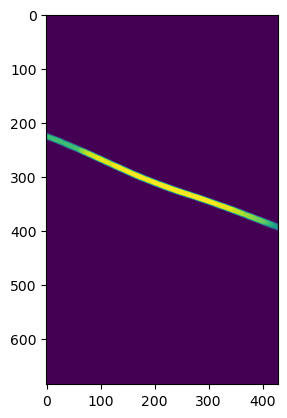

In [4]:
from Filament_Analysis.various_funcs import niblack_threshold

framenums = [n for n in range(0, len(images_0)) if n%50 == 0]
avg_img = np.zeros_like(images_0[0], dtype=np.uint16)
for n in framenums:
    avg_img = avg_img + niblack_threshold(images_0[n],blob_size_thr = 1000)
#avg_img = avg_img / len(framenums)

plt.imshow(avg_img)

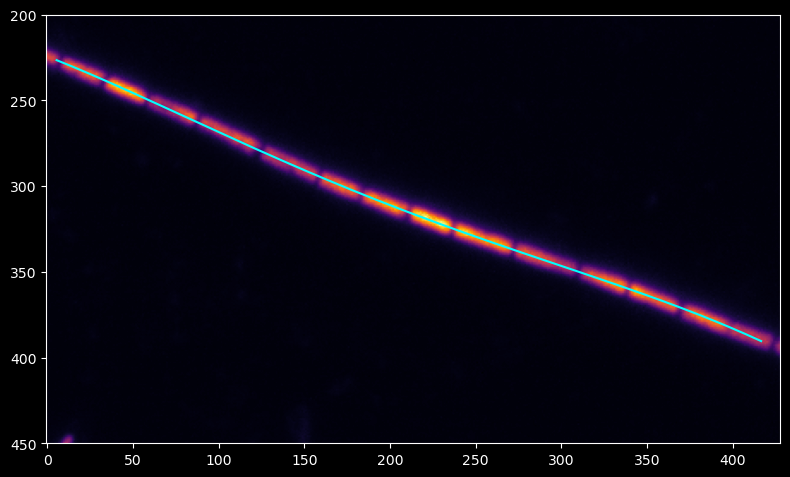

In [8]:
filament_axis = SimpleSpline.from_binary_image(dx=0.01,input_image=avg_img > 0, spline_k = 5)

#Sometimes the spline goes beyond the image dimensions and causes issues
filament_axis.crop_to_image_dimensions(images_0[0].shape)


# Visualise the spline
with plt.style.context('dark_background'):
    fig , ax = plt.subplots(1,1, figsize=(8,5))

    ax.imshow(images_0[850], cmap='inferno')
    ax.plot(filament_axis.xy[500:-1000,0], filament_axis.xy[500:-1000:,1], color='cyan')
    ax.set_ylim(450,200)
    plt.tight_layout()
    plt.show()

In [15]:
#Save Splines
axes_path = base_path.joinpath(r'FilamentAxes\29-Nov-22_Todays_Sample_TIRF_473')

splines = [filament_axis.xy[500:-1000,:]]

fnames = ['spline_0.txt']

headers = ['18/06/2023']

for k,name in enumerate(fnames):
    axes_path.mkdir(parents=True, exist_ok=True)
    np.savetxt(axes_path.joinpath(name),splines[k],delimiter = ',', header = headers[k])